In [1]:
# !pip install git+https://github.com/miguelcarcamov/csromer@feature/refactoring-dataclasses

In [2]:
import copy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy import stats
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import FISTA, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers.dfts import NDFT1D, NUFFT1D
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [3]:
np.random.seed(666)

In [4]:
nu = np.linspace(start=0.89e9, stop=1.681e9, num=1000)  # MeerKAT Larry's config

In [5]:
# thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=0.0)

In [6]:
thicksource = FaradayThickSource(nu=nu, s_nu=1.0, phi_fg=90., phi_center=200., spectral_idx=0.0)

In [7]:
thicksource.simulate()

In [8]:
simsource_nolambda2_0 = thicksource
simsource = copy.deepcopy(thicksource)

In [9]:
simsource.l2_ref = simsource.calculate_l2ref()

In [10]:
simsource_nolambda2_0.apply_noise(0.01)
simsource.apply_noise(0.01)

In [11]:
parameter_nolambda2_0 = Parameter()
parameter = Parameter()

In [12]:
parameter_nolambda2_0.calculate_cellsize(dataset=simsource_nolambda2_0, oversampling=8)

FWHM of the main peak of the RMTF: 42.422 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21189.543


In [13]:
parameter.calculate_cellsize(dataset=simsource, oversampling=8)

FWHM of the main peak of the RMTF: 42.422 rad/m^2
Maximum recovered width structure: 98.774 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21189.543


In [14]:
dft_nolambda2_0 = NDFT1D(dataset=simsource_nolambda2_0, parameter=parameter_nolambda2_0)
dft = NDFT1D(dataset=simsource, parameter=parameter)

In [15]:
F_dirty_nolambda2_0 = dft_nolambda2_0.backward(simsource_nolambda2_0.data)
F_dirty = dft.backward(simsource.data)

rmtf_nolambda2_0 = dft_nolambda2_0.RMTF()
rmtf = dft.RMTF()

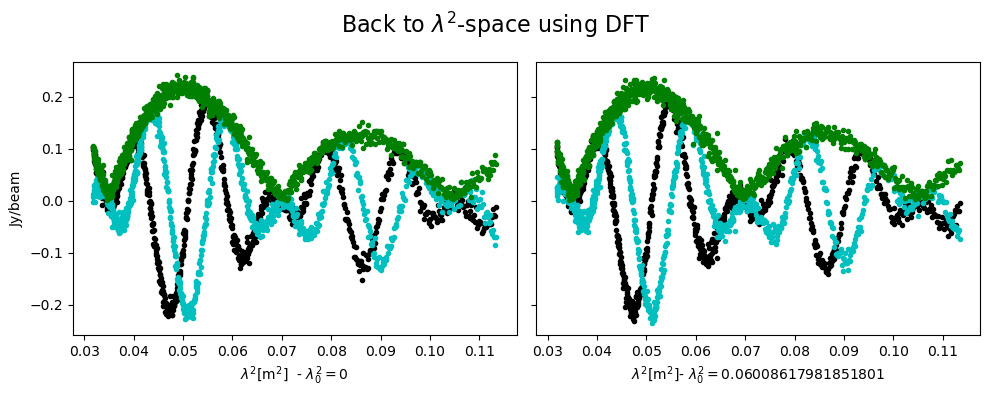

In [16]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(
    simsource_nolambda2_0.lambda2, simsource_nolambda2_0.data.real, 'k.', label=r"Stokes $Q$"
)
ax[0].plot(
    simsource_nolambda2_0.lambda2, simsource_nolambda2_0.data.imag, 'c.', label=r"Stokes $U$"
)
ax[0].plot(simsource_nolambda2_0.lambda2, np.abs(simsource_nolambda2_0.data), 'g.', label=r"$|P|$")
ax[0].set_xlabel(r'$\lambda^2$[m$^{2}$]  - $\lambda^2_0 = 0$')
ax[0].set_ylabel(r'Jy/beam')

ax[1].plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
ax[1].plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
ax[1].plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
ax[1].set_xlabel(r'$\lambda^2$[m$^{2}$]- $\lambda^2_0 =' + str(simsource.l2_ref) + '$')

fig.suptitle(r'Back to $\lambda^2$-space using DFT', fontsize=16)

plt.tight_layout()

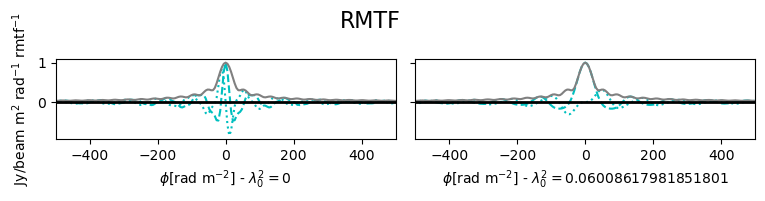

In [17]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter_nolambda2_0.phi, rmtf_nolambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter_nolambda2_0.phi, rmtf_nolambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter_nolambda2_0.phi, np.abs(rmtf_nolambda2_0), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(
    parameter_nolambda2_0.phi, np.zeros(len(parameter_nolambda2_0.phi)), ls='-', lw=2., c='black'
)
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$] - $\lambda^2_0 = 0$')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-500, 500])

ax[1].plot(parameter.phi, rmtf.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, rmtf.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(rmtf), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$] - $\lambda^2_0 =' + str(simsource.l2_ref) + "$")
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-500, 500])

fig.suptitle('RMTF', fontsize=16)

plt.tight_layout()

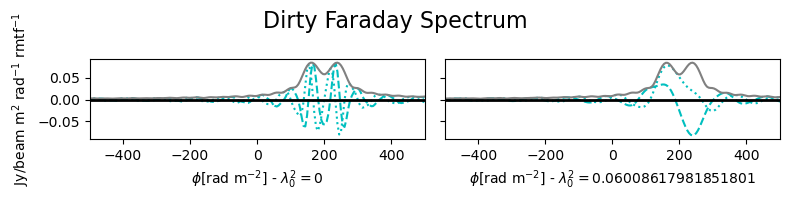

In [18]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter_nolambda2_0.phi, F_dirty_nolambda2_0.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter_nolambda2_0.phi, F_dirty_nolambda2_0.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter_nolambda2_0.phi, np.abs(F_dirty_nolambda2_0), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(
    parameter_nolambda2_0.phi, np.zeros(len(parameter_nolambda2_0.phi)), ls='-', lw=2., c='black'
)
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$] - $\lambda^2_0 = 0$')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-500, 500])

ax[1].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$] - $\lambda^2_0 =' + str(simsource.l2_ref) + '$')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-500, 500])

fig.suptitle('Dirty Faraday Spectrum', fontsize=16)

plt.tight_layout()

In [19]:
# Get back to lambda^2-space from Faraday depth space
nolambda2_0_back = dft_nolambda2_0.forward_normalized(F_dirty_nolambda2_0)
lambda2_back = dft.forward_normalized(F_dirty)

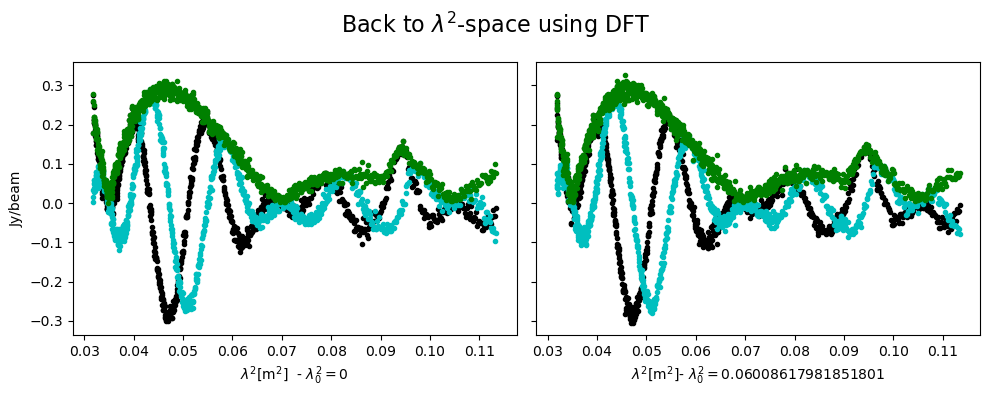

In [20]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(simsource_nolambda2_0.lambda2, nolambda2_0_back.real, 'k.', label=r"Stokes $Q$")
ax[0].plot(simsource_nolambda2_0.lambda2, nolambda2_0_back.imag, 'c.', label=r"Stokes $U$")
ax[0].plot(simsource_nolambda2_0.lambda2, np.abs(nolambda2_0_back), 'g.', label=r"$|P|$")
ax[0].set_xlabel(r'$\lambda^2$[m$^{2}$]  - $\lambda^2_0 = 0$')
ax[0].set_ylabel(r'Jy/beam')

ax[1].plot(simsource.lambda2, lambda2_back.real, 'k.', label=r"Stokes $Q$")
ax[1].plot(simsource.lambda2, lambda2_back.imag, 'c.', label=r"Stokes $U$")
ax[1].plot(simsource.lambda2, np.abs(lambda2_back), 'g.', label=r"$|P|$")
ax[1].set_xlabel(r'$\lambda^2$[m$^{2}$]- $\lambda^2_0 =' + str(simsource.l2_ref) + '$')

fig.suptitle(r'Back to $\lambda^2$-space using DFT', fontsize=16)

plt.tight_layout()